# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

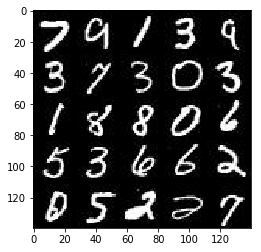

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

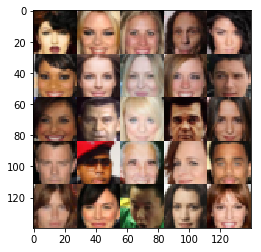

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        conv3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)

        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    
    with tf.variable_scope('generator', reuse=not is_train):
    
        fc = tf.layers.dense(z, 7*7*256)
        fc = tf.reshape(fc, (-1, 7, 7, 256))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        
        deconv2 = tf.layers.conv2d_transpose(fc, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2 = tf.maximum(alpha*deconv2, deconv2)
        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_train)
        deconv3 = tf.maximum(alpha*deconv3, deconv3)
        
        logits = tf.layers.conv2d_transpose(deconv3, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)        

    return out




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
     
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    steps = 0
    show_every = 100
    print_every = 10
    n_images = 32
    
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
     
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:    
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.4956... Generator Loss: 1.1712
Epoch 0/2... Discriminator Loss: 4.3349... Generator Loss: 0.0706
Epoch 0/2... Discriminator Loss: 1.7523... Generator Loss: 0.5525
Epoch 0/2... Discriminator Loss: 1.4167... Generator Loss: 0.6728
Epoch 0/2... Discriminator Loss: 1.5438... Generator Loss: 0.7164
Epoch 0/2... Discriminator Loss: 1.8916... Generator Loss: 0.2722
Epoch 0/2... Discriminator Loss: 1.5094... Generator Loss: 0.7405
Epoch 0/2... Discriminator Loss: 1.4585... Generator Loss: 1.4069
Epoch 0/2... Discriminator Loss: 1.2034... Generator Loss: 1.2700
Epoch 0/2... Discriminator Loss: 1.5032... Generator Loss: 0.4620


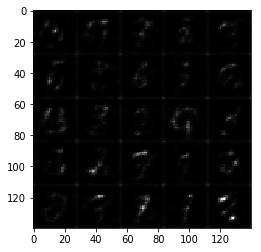

Epoch 0/2... Discriminator Loss: 1.2373... Generator Loss: 1.2339
Epoch 0/2... Discriminator Loss: 1.3166... Generator Loss: 1.4813
Epoch 0/2... Discriminator Loss: 1.3722... Generator Loss: 0.5160
Epoch 0/2... Discriminator Loss: 1.0371... Generator Loss: 1.2571
Epoch 0/2... Discriminator Loss: 1.5277... Generator Loss: 0.4525
Epoch 0/2... Discriminator Loss: 1.2074... Generator Loss: 0.7045
Epoch 0/2... Discriminator Loss: 1.0828... Generator Loss: 1.0960
Epoch 0/2... Discriminator Loss: 1.1570... Generator Loss: 1.8224
Epoch 0/2... Discriminator Loss: 1.2335... Generator Loss: 0.6226
Epoch 0/2... Discriminator Loss: 1.0871... Generator Loss: 1.5695


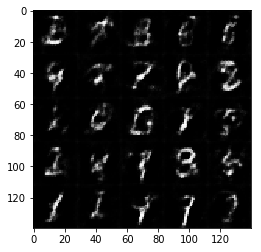

Epoch 0/2... Discriminator Loss: 1.2191... Generator Loss: 0.9014
Epoch 0/2... Discriminator Loss: 1.2993... Generator Loss: 0.6583
Epoch 0/2... Discriminator Loss: 1.0746... Generator Loss: 1.1814
Epoch 0/2... Discriminator Loss: 1.1817... Generator Loss: 0.7997
Epoch 0/2... Discriminator Loss: 1.2845... Generator Loss: 0.6865
Epoch 0/2... Discriminator Loss: 1.0572... Generator Loss: 1.5006
Epoch 0/2... Discriminator Loss: 1.0972... Generator Loss: 1.2317
Epoch 0/2... Discriminator Loss: 1.0953... Generator Loss: 0.8356
Epoch 0/2... Discriminator Loss: 1.0073... Generator Loss: 1.2817
Epoch 0/2... Discriminator Loss: 1.4300... Generator Loss: 0.4744


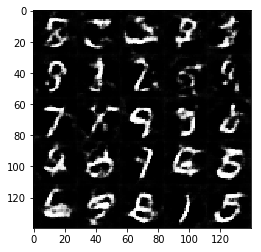

Epoch 0/2... Discriminator Loss: 1.2990... Generator Loss: 0.6155
Epoch 0/2... Discriminator Loss: 1.0434... Generator Loss: 1.8051
Epoch 0/2... Discriminator Loss: 1.1232... Generator Loss: 1.4968
Epoch 0/2... Discriminator Loss: 1.1694... Generator Loss: 0.7828
Epoch 0/2... Discriminator Loss: 1.1959... Generator Loss: 0.6990
Epoch 0/2... Discriminator Loss: 1.3379... Generator Loss: 0.5594
Epoch 0/2... Discriminator Loss: 1.2221... Generator Loss: 0.6819
Epoch 0/2... Discriminator Loss: 0.9332... Generator Loss: 1.5255
Epoch 0/2... Discriminator Loss: 1.0320... Generator Loss: 0.8787
Epoch 0/2... Discriminator Loss: 0.9362... Generator Loss: 1.1050


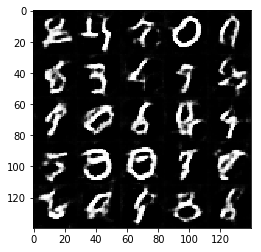

Epoch 0/2... Discriminator Loss: 1.2251... Generator Loss: 0.6515
Epoch 0/2... Discriminator Loss: 1.2065... Generator Loss: 1.8934
Epoch 0/2... Discriminator Loss: 1.2520... Generator Loss: 2.0351
Epoch 0/2... Discriminator Loss: 1.2761... Generator Loss: 0.5973
Epoch 0/2... Discriminator Loss: 1.1378... Generator Loss: 0.8142
Epoch 0/2... Discriminator Loss: 1.4986... Generator Loss: 2.3502
Epoch 0/2... Discriminator Loss: 1.1438... Generator Loss: 1.7241
Epoch 0/2... Discriminator Loss: 1.0244... Generator Loss: 1.0330
Epoch 0/2... Discriminator Loss: 1.4536... Generator Loss: 0.4641
Epoch 0/2... Discriminator Loss: 1.0535... Generator Loss: 1.0164


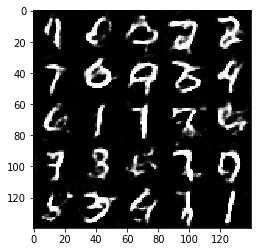

Epoch 0/2... Discriminator Loss: 1.0626... Generator Loss: 1.8820
Epoch 0/2... Discriminator Loss: 0.8506... Generator Loss: 1.6557
Epoch 0/2... Discriminator Loss: 1.0326... Generator Loss: 1.6289
Epoch 0/2... Discriminator Loss: 1.3129... Generator Loss: 0.5740
Epoch 0/2... Discriminator Loss: 1.0896... Generator Loss: 1.4031
Epoch 0/2... Discriminator Loss: 1.0523... Generator Loss: 1.1597
Epoch 0/2... Discriminator Loss: 1.0650... Generator Loss: 2.0922
Epoch 0/2... Discriminator Loss: 0.9268... Generator Loss: 1.3605
Epoch 0/2... Discriminator Loss: 1.0437... Generator Loss: 0.9039
Epoch 0/2... Discriminator Loss: 0.9082... Generator Loss: 1.1392


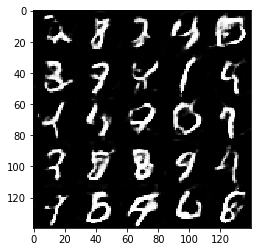

Epoch 0/2... Discriminator Loss: 1.2514... Generator Loss: 0.6264
Epoch 0/2... Discriminator Loss: 0.9558... Generator Loss: 1.4136
Epoch 0/2... Discriminator Loss: 1.1199... Generator Loss: 1.6842
Epoch 0/2... Discriminator Loss: 0.9721... Generator Loss: 1.1395
Epoch 0/2... Discriminator Loss: 1.3213... Generator Loss: 0.7605
Epoch 0/2... Discriminator Loss: 1.0004... Generator Loss: 1.0409
Epoch 0/2... Discriminator Loss: 0.8820... Generator Loss: 1.5514
Epoch 0/2... Discriminator Loss: 1.2119... Generator Loss: 0.6705
Epoch 0/2... Discriminator Loss: 0.8939... Generator Loss: 1.1639
Epoch 0/2... Discriminator Loss: 0.9108... Generator Loss: 1.8128


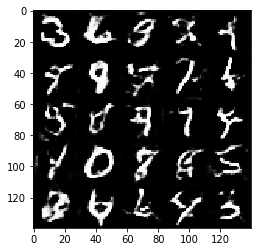

Epoch 0/2... Discriminator Loss: 1.2362... Generator Loss: 0.7702
Epoch 0/2... Discriminator Loss: 1.0942... Generator Loss: 1.0612
Epoch 0/2... Discriminator Loss: 1.1038... Generator Loss: 0.8028
Epoch 0/2... Discriminator Loss: 0.8954... Generator Loss: 1.3628
Epoch 0/2... Discriminator Loss: 1.4425... Generator Loss: 0.4841
Epoch 0/2... Discriminator Loss: 0.9625... Generator Loss: 1.0161
Epoch 0/2... Discriminator Loss: 1.5919... Generator Loss: 2.4455
Epoch 0/2... Discriminator Loss: 1.0473... Generator Loss: 0.9083
Epoch 0/2... Discriminator Loss: 0.9375... Generator Loss: 1.0595
Epoch 0/2... Discriminator Loss: 1.0221... Generator Loss: 0.8914


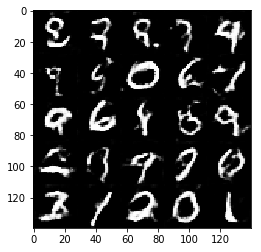

Epoch 0/2... Discriminator Loss: 1.1163... Generator Loss: 0.7326
Epoch 0/2... Discriminator Loss: 0.8861... Generator Loss: 1.7172
Epoch 0/2... Discriminator Loss: 1.6549... Generator Loss: 0.4311
Epoch 0/2... Discriminator Loss: 0.9231... Generator Loss: 1.2880
Epoch 0/2... Discriminator Loss: 2.1381... Generator Loss: 0.2732
Epoch 0/2... Discriminator Loss: 1.1934... Generator Loss: 0.6577
Epoch 0/2... Discriminator Loss: 1.0572... Generator Loss: 1.3268
Epoch 0/2... Discriminator Loss: 0.7077... Generator Loss: 2.0668
Epoch 0/2... Discriminator Loss: 0.8686... Generator Loss: 1.2635
Epoch 0/2... Discriminator Loss: 1.2352... Generator Loss: 1.9408


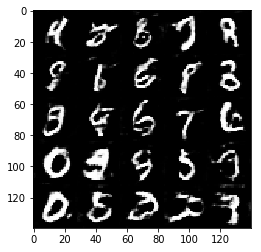

Epoch 0/2... Discriminator Loss: 1.3067... Generator Loss: 0.6167
Epoch 0/2... Discriminator Loss: 0.8866... Generator Loss: 1.4850
Epoch 0/2... Discriminator Loss: 1.5733... Generator Loss: 2.3581
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.4372
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 2.2259
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 1.1554
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 1.2965


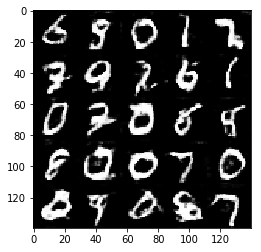

Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 1.9551
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 1.2674
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 1.9209
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.5120
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.1100
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 0.7289... Generator Loss: 1.5498
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 0.8227


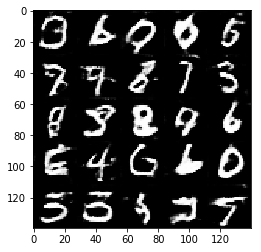

Epoch 1/2... Discriminator Loss: 0.7054... Generator Loss: 1.4473
Epoch 1/2... Discriminator Loss: 2.7365... Generator Loss: 0.1767
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.1318
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 0.9142... Generator Loss: 2.4970
Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 1.6358
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 1.6566


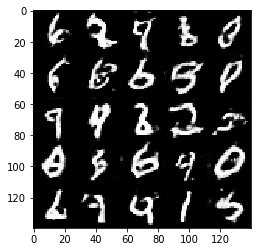

Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.5781
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.2818
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.0809
Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 1.9686
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.3399
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 2.0213... Generator Loss: 3.5006
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.8302
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 2.1527


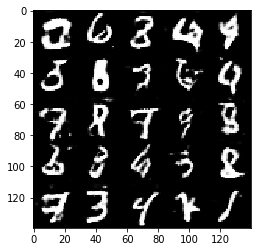

Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.5787
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.4689
Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 1.3274
Epoch 1/2... Discriminator Loss: 0.5698... Generator Loss: 2.0372


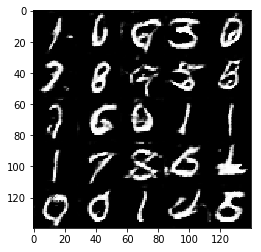

Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 2.4517
Epoch 1/2... Discriminator Loss: 0.8133... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 4.7416... Generator Loss: 7.1602
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.6076
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 1.5977
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 1.5365
Epoch 1/2... Discriminator Loss: 0.6453... Generator Loss: 2.1984
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 1.7411


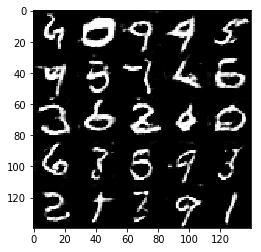

Epoch 1/2... Discriminator Loss: 2.8762... Generator Loss: 0.1528
Epoch 1/2... Discriminator Loss: 0.7657... Generator Loss: 1.3550
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.8560
Epoch 1/2... Discriminator Loss: 0.6801... Generator Loss: 2.0395
Epoch 1/2... Discriminator Loss: 1.9190... Generator Loss: 0.3688
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.6460
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 0.7047... Generator Loss: 1.6960
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 1.7554


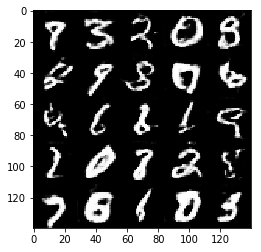

Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 0.9421
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.4129
Epoch 1/2... Discriminator Loss: 0.6533... Generator Loss: 2.0290
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.4703
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 1.4316
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 1.8657
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 1.8682
Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 2.1079
Epoch 1/2... Discriminator Loss: 0.6487... Generator Loss: 1.9487
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 2.0528


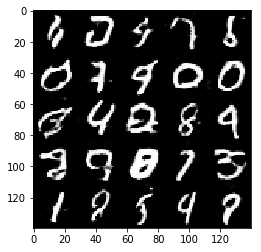

Epoch 1/2... Discriminator Loss: 0.5064... Generator Loss: 2.4302
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.2054... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 1.4912
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 2.3282
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.5812
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 3.2233
Epoch 1/2... Discriminator Loss: 0.8220... Generator Loss: 2.5468


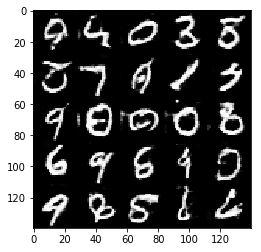

Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.8558
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 0.9812
Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 1.1695
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 2.3137
Epoch 1/2... Discriminator Loss: 0.4825... Generator Loss: 2.5280
Epoch 1/2... Discriminator Loss: 0.8024... Generator Loss: 1.4704


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.7226... Generator Loss: 2.3158
Epoch 0/1... Discriminator Loss: 0.7223... Generator Loss: 4.2668
Epoch 0/1... Discriminator Loss: 1.5168... Generator Loss: 0.6042
Epoch 0/1... Discriminator Loss: 1.1361... Generator Loss: 0.9358
Epoch 0/1... Discriminator Loss: 0.8182... Generator Loss: 1.5819
Epoch 0/1... Discriminator Loss: 0.7651... Generator Loss: 2.9547
Epoch 0/1... Discriminator Loss: 0.7147... Generator Loss: 2.2802
Epoch 0/1... Discriminator Loss: 0.9451... Generator Loss: 0.9747
Epoch 0/1... Discriminator Loss: 0.9769... Generator Loss: 1.6245
Epoch 0/1... Discriminator Loss: 0.7775... Generator Loss: 1.3759


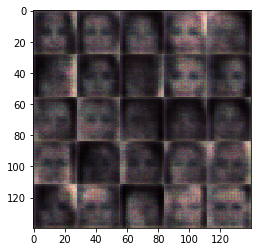

Epoch 0/1... Discriminator Loss: 0.5068... Generator Loss: 3.2730
Epoch 0/1... Discriminator Loss: 1.1427... Generator Loss: 1.3963
Epoch 0/1... Discriminator Loss: 1.7319... Generator Loss: 0.4275
Epoch 0/1... Discriminator Loss: 1.0042... Generator Loss: 1.1584
Epoch 0/1... Discriminator Loss: 1.0024... Generator Loss: 1.4528
Epoch 0/1... Discriminator Loss: 2.3064... Generator Loss: 0.1748
Epoch 0/1... Discriminator Loss: 1.3768... Generator Loss: 0.6847
Epoch 0/1... Discriminator Loss: 0.6659... Generator Loss: 1.8437
Epoch 0/1... Discriminator Loss: 1.0293... Generator Loss: 1.3619
Epoch 0/1... Discriminator Loss: 1.2473... Generator Loss: 0.9488


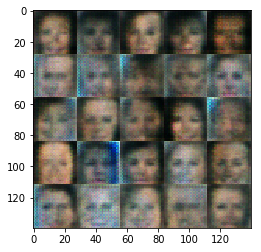

Epoch 0/1... Discriminator Loss: 1.7124... Generator Loss: 1.4219
Epoch 0/1... Discriminator Loss: 1.6715... Generator Loss: 0.6466
Epoch 0/1... Discriminator Loss: 1.9837... Generator Loss: 0.3546
Epoch 0/1... Discriminator Loss: 1.2573... Generator Loss: 0.7272
Epoch 0/1... Discriminator Loss: 1.4077... Generator Loss: 2.3983
Epoch 0/1... Discriminator Loss: 1.8267... Generator Loss: 2.3480
Epoch 0/1... Discriminator Loss: 1.0610... Generator Loss: 0.8231
Epoch 0/1... Discriminator Loss: 1.4866... Generator Loss: 0.9943
Epoch 0/1... Discriminator Loss: 1.4434... Generator Loss: 0.7812
Epoch 0/1... Discriminator Loss: 1.3277... Generator Loss: 0.8729


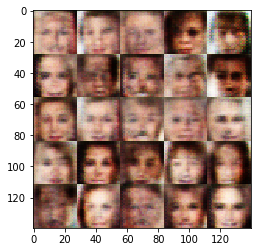

Epoch 0/1... Discriminator Loss: 1.2558... Generator Loss: 0.8285
Epoch 0/1... Discriminator Loss: 1.0806... Generator Loss: 0.9772
Epoch 0/1... Discriminator Loss: 0.9953... Generator Loss: 0.9233
Epoch 0/1... Discriminator Loss: 1.1111... Generator Loss: 1.1557
Epoch 0/1... Discriminator Loss: 1.4252... Generator Loss: 0.6876
Epoch 0/1... Discriminator Loss: 1.2314... Generator Loss: 1.0104
Epoch 0/1... Discriminator Loss: 1.4502... Generator Loss: 1.1797
Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 0.5439
Epoch 0/1... Discriminator Loss: 1.1729... Generator Loss: 0.8022
Epoch 0/1... Discriminator Loss: 1.1971... Generator Loss: 0.8919


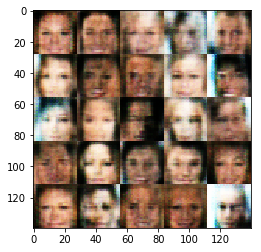

Epoch 0/1... Discriminator Loss: 1.3658... Generator Loss: 0.8163
Epoch 0/1... Discriminator Loss: 1.2535... Generator Loss: 0.7671
Epoch 0/1... Discriminator Loss: 0.9976... Generator Loss: 1.0409
Epoch 0/1... Discriminator Loss: 0.6869... Generator Loss: 1.5132
Epoch 0/1... Discriminator Loss: 1.4690... Generator Loss: 0.5385
Epoch 0/1... Discriminator Loss: 1.2360... Generator Loss: 0.9034
Epoch 0/1... Discriminator Loss: 1.7572... Generator Loss: 0.7657
Epoch 0/1... Discriminator Loss: 1.2816... Generator Loss: 0.7843
Epoch 0/1... Discriminator Loss: 1.3924... Generator Loss: 0.8568
Epoch 0/1... Discriminator Loss: 1.3034... Generator Loss: 0.7532


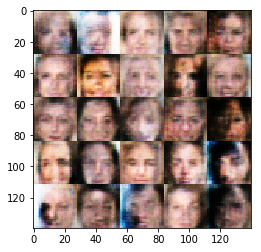

Epoch 0/1... Discriminator Loss: 1.3741... Generator Loss: 0.6109
Epoch 0/1... Discriminator Loss: 1.2286... Generator Loss: 1.1001
Epoch 0/1... Discriminator Loss: 0.9874... Generator Loss: 0.9103
Epoch 0/1... Discriminator Loss: 1.3911... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 1.3557... Generator Loss: 0.6440
Epoch 0/1... Discriminator Loss: 0.9089... Generator Loss: 1.4023
Epoch 0/1... Discriminator Loss: 1.2600... Generator Loss: 0.7229
Epoch 0/1... Discriminator Loss: 1.2869... Generator Loss: 0.8154
Epoch 0/1... Discriminator Loss: 1.4533... Generator Loss: 1.2281
Epoch 0/1... Discriminator Loss: 1.1718... Generator Loss: 0.7128


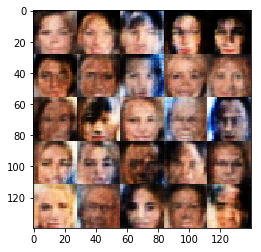

Epoch 0/1... Discriminator Loss: 1.2359... Generator Loss: 0.8159
Epoch 0/1... Discriminator Loss: 1.2168... Generator Loss: 0.8407
Epoch 0/1... Discriminator Loss: 1.5328... Generator Loss: 0.9719
Epoch 0/1... Discriminator Loss: 1.3570... Generator Loss: 0.8315
Epoch 0/1... Discriminator Loss: 1.4679... Generator Loss: 0.7824
Epoch 0/1... Discriminator Loss: 1.2793... Generator Loss: 1.1191
Epoch 0/1... Discriminator Loss: 1.2439... Generator Loss: 0.7095
Epoch 0/1... Discriminator Loss: 1.6196... Generator Loss: 0.5161
Epoch 0/1... Discriminator Loss: 1.4187... Generator Loss: 0.7829
Epoch 0/1... Discriminator Loss: 1.5226... Generator Loss: 0.7599


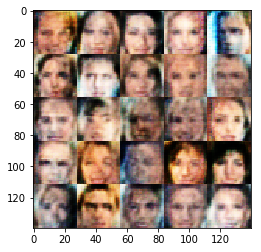

Epoch 0/1... Discriminator Loss: 1.3855... Generator Loss: 0.8724
Epoch 0/1... Discriminator Loss: 1.3341... Generator Loss: 0.7203
Epoch 0/1... Discriminator Loss: 1.5991... Generator Loss: 0.6542
Epoch 0/1... Discriminator Loss: 1.3206... Generator Loss: 0.8112
Epoch 0/1... Discriminator Loss: 1.3727... Generator Loss: 0.8208
Epoch 0/1... Discriminator Loss: 1.4286... Generator Loss: 0.7927
Epoch 0/1... Discriminator Loss: 1.3620... Generator Loss: 0.8695
Epoch 0/1... Discriminator Loss: 1.4047... Generator Loss: 0.5495
Epoch 0/1... Discriminator Loss: 1.3551... Generator Loss: 0.7866
Epoch 0/1... Discriminator Loss: 1.4481... Generator Loss: 0.8469


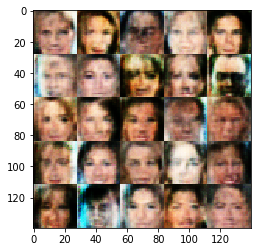

Epoch 0/1... Discriminator Loss: 1.2432... Generator Loss: 0.9156
Epoch 0/1... Discriminator Loss: 1.2800... Generator Loss: 0.7305
Epoch 0/1... Discriminator Loss: 1.3438... Generator Loss: 0.8859
Epoch 0/1... Discriminator Loss: 1.3717... Generator Loss: 0.8683
Epoch 0/1... Discriminator Loss: 1.3498... Generator Loss: 1.3582
Epoch 0/1... Discriminator Loss: 1.2865... Generator Loss: 0.8577
Epoch 0/1... Discriminator Loss: 1.2924... Generator Loss: 0.7597
Epoch 0/1... Discriminator Loss: 1.3555... Generator Loss: 0.6339
Epoch 0/1... Discriminator Loss: 1.4043... Generator Loss: 0.5895
Epoch 0/1... Discriminator Loss: 1.2736... Generator Loss: 0.8470


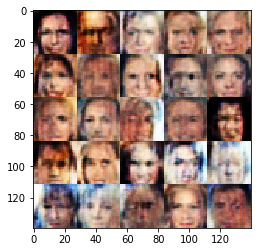

Epoch 0/1... Discriminator Loss: 1.3988... Generator Loss: 0.7800
Epoch 0/1... Discriminator Loss: 1.2950... Generator Loss: 0.7963
Epoch 0/1... Discriminator Loss: 1.2522... Generator Loss: 0.8372
Epoch 0/1... Discriminator Loss: 1.4325... Generator Loss: 1.0200
Epoch 0/1... Discriminator Loss: 1.3473... Generator Loss: 0.6686
Epoch 0/1... Discriminator Loss: 1.3440... Generator Loss: 0.8039
Epoch 0/1... Discriminator Loss: 1.2138... Generator Loss: 1.0551
Epoch 0/1... Discriminator Loss: 1.3790... Generator Loss: 0.6081
Epoch 0/1... Discriminator Loss: 1.5427... Generator Loss: 0.8240
Epoch 0/1... Discriminator Loss: 1.3163... Generator Loss: 1.0274


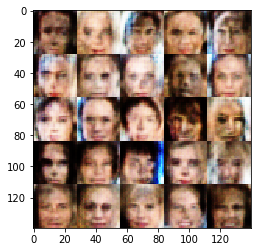

Epoch 0/1... Discriminator Loss: 1.4658... Generator Loss: 0.6287
Epoch 0/1... Discriminator Loss: 1.3854... Generator Loss: 0.7559
Epoch 0/1... Discriminator Loss: 1.1765... Generator Loss: 1.0013
Epoch 0/1... Discriminator Loss: 1.3344... Generator Loss: 0.7539
Epoch 0/1... Discriminator Loss: 1.3291... Generator Loss: 0.9279
Epoch 0/1... Discriminator Loss: 1.3737... Generator Loss: 0.5136
Epoch 0/1... Discriminator Loss: 1.2723... Generator Loss: 1.1924
Epoch 0/1... Discriminator Loss: 1.2816... Generator Loss: 0.9403
Epoch 0/1... Discriminator Loss: 1.2521... Generator Loss: 0.6607
Epoch 0/1... Discriminator Loss: 1.3367... Generator Loss: 1.0371


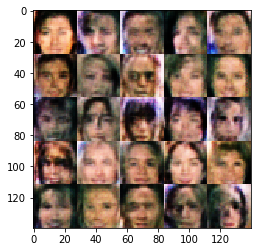

Epoch 0/1... Discriminator Loss: 1.3117... Generator Loss: 0.8356
Epoch 0/1... Discriminator Loss: 1.2219... Generator Loss: 0.8285
Epoch 0/1... Discriminator Loss: 1.3133... Generator Loss: 0.8925
Epoch 0/1... Discriminator Loss: 1.3000... Generator Loss: 1.1585
Epoch 0/1... Discriminator Loss: 1.1475... Generator Loss: 1.5825
Epoch 0/1... Discriminator Loss: 1.4880... Generator Loss: 1.1559
Epoch 0/1... Discriminator Loss: 1.3035... Generator Loss: 0.7900
Epoch 0/1... Discriminator Loss: 1.3024... Generator Loss: 1.0074
Epoch 0/1... Discriminator Loss: 1.4265... Generator Loss: 0.5461
Epoch 0/1... Discriminator Loss: 1.8118... Generator Loss: 2.3605


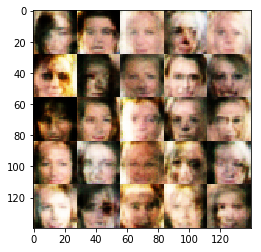

Epoch 0/1... Discriminator Loss: 1.3098... Generator Loss: 0.8680
Epoch 0/1... Discriminator Loss: 1.2841... Generator Loss: 0.9355
Epoch 0/1... Discriminator Loss: 1.4403... Generator Loss: 0.6001
Epoch 0/1... Discriminator Loss: 1.0158... Generator Loss: 1.4808
Epoch 0/1... Discriminator Loss: 1.3827... Generator Loss: 0.9972
Epoch 0/1... Discriminator Loss: 1.3123... Generator Loss: 0.8440
Epoch 0/1... Discriminator Loss: 1.1666... Generator Loss: 0.7578
Epoch 0/1... Discriminator Loss: 1.4584... Generator Loss: 1.3265
Epoch 0/1... Discriminator Loss: 1.4436... Generator Loss: 0.6381
Epoch 0/1... Discriminator Loss: 1.3019... Generator Loss: 0.7160


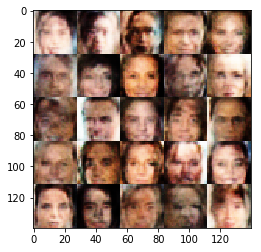

Epoch 0/1... Discriminator Loss: 1.2788... Generator Loss: 0.8018
Epoch 0/1... Discriminator Loss: 1.4024... Generator Loss: 0.8143
Epoch 0/1... Discriminator Loss: 1.3131... Generator Loss: 0.7003
Epoch 0/1... Discriminator Loss: 1.4209... Generator Loss: 0.8044
Epoch 0/1... Discriminator Loss: 1.1743... Generator Loss: 1.1376
Epoch 0/1... Discriminator Loss: 1.3609... Generator Loss: 0.8232
Epoch 0/1... Discriminator Loss: 1.3220... Generator Loss: 0.9834
Epoch 0/1... Discriminator Loss: 1.2886... Generator Loss: 0.7667
Epoch 0/1... Discriminator Loss: 1.2505... Generator Loss: 1.0218
Epoch 0/1... Discriminator Loss: 1.3478... Generator Loss: 0.7059


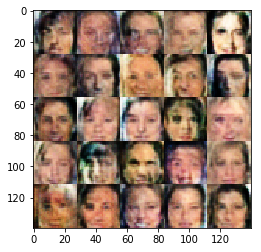

Epoch 0/1... Discriminator Loss: 1.0974... Generator Loss: 1.2789
Epoch 0/1... Discriminator Loss: 1.3059... Generator Loss: 0.7932
Epoch 0/1... Discriminator Loss: 1.3632... Generator Loss: 0.7196
Epoch 0/1... Discriminator Loss: 1.2447... Generator Loss: 0.9054
Epoch 0/1... Discriminator Loss: 1.3457... Generator Loss: 0.9651
Epoch 0/1... Discriminator Loss: 1.3191... Generator Loss: 0.7613
Epoch 0/1... Discriminator Loss: 1.1965... Generator Loss: 1.0210
Epoch 0/1... Discriminator Loss: 1.1719... Generator Loss: 0.8550
Epoch 0/1... Discriminator Loss: 1.2530... Generator Loss: 1.1719
Epoch 0/1... Discriminator Loss: 1.3024... Generator Loss: 1.0158


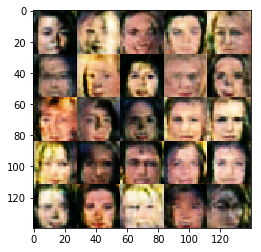

Epoch 0/1... Discriminator Loss: 1.3487... Generator Loss: 1.4209
Epoch 0/1... Discriminator Loss: 1.2048... Generator Loss: 0.7538
Epoch 0/1... Discriminator Loss: 1.3821... Generator Loss: 0.5888
Epoch 0/1... Discriminator Loss: 1.2217... Generator Loss: 0.7571
Epoch 0/1... Discriminator Loss: 1.2625... Generator Loss: 0.6184
Epoch 0/1... Discriminator Loss: 1.1088... Generator Loss: 0.8503
Epoch 0/1... Discriminator Loss: 1.2726... Generator Loss: 0.8764
Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 0.8602
Epoch 0/1... Discriminator Loss: 1.6473... Generator Loss: 0.3749
Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 1.2121


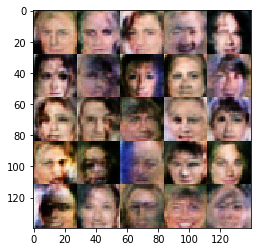

Epoch 0/1... Discriminator Loss: 1.3103... Generator Loss: 0.7170
Epoch 0/1... Discriminator Loss: 1.3398... Generator Loss: 0.7963
Epoch 0/1... Discriminator Loss: 1.3734... Generator Loss: 0.9600
Epoch 0/1... Discriminator Loss: 1.2615... Generator Loss: 0.8270
Epoch 0/1... Discriminator Loss: 1.2710... Generator Loss: 0.8014
Epoch 0/1... Discriminator Loss: 1.1765... Generator Loss: 0.9193
Epoch 0/1... Discriminator Loss: 1.5115... Generator Loss: 3.3481
Epoch 0/1... Discriminator Loss: 1.4682... Generator Loss: 0.5572
Epoch 0/1... Discriminator Loss: 1.1466... Generator Loss: 0.9761
Epoch 0/1... Discriminator Loss: 1.2412... Generator Loss: 1.3359


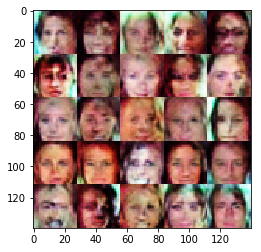

Epoch 0/1... Discriminator Loss: 1.4392... Generator Loss: 0.4644
Epoch 0/1... Discriminator Loss: 1.4056... Generator Loss: 0.6005
Epoch 0/1... Discriminator Loss: 1.2950... Generator Loss: 0.8368
Epoch 0/1... Discriminator Loss: 1.3995... Generator Loss: 1.0610
Epoch 0/1... Discriminator Loss: 1.3875... Generator Loss: 0.6365
Epoch 0/1... Discriminator Loss: 1.4246... Generator Loss: 0.7030
Epoch 0/1... Discriminator Loss: 1.1611... Generator Loss: 1.0302
Epoch 0/1... Discriminator Loss: 1.3661... Generator Loss: 0.6371
Epoch 0/1... Discriminator Loss: 1.3013... Generator Loss: 0.7828
Epoch 0/1... Discriminator Loss: 1.3084... Generator Loss: 0.8468


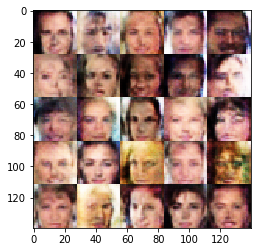

Epoch 0/1... Discriminator Loss: 1.3246... Generator Loss: 0.7841
Epoch 0/1... Discriminator Loss: 1.3849... Generator Loss: 1.6888
Epoch 0/1... Discriminator Loss: 1.2262... Generator Loss: 0.8024
Epoch 0/1... Discriminator Loss: 1.2446... Generator Loss: 0.9605
Epoch 0/1... Discriminator Loss: 1.1300... Generator Loss: 0.9497
Epoch 0/1... Discriminator Loss: 1.4563... Generator Loss: 0.8891
Epoch 0/1... Discriminator Loss: 1.3230... Generator Loss: 1.3135
Epoch 0/1... Discriminator Loss: 1.2647... Generator Loss: 0.7883
Epoch 0/1... Discriminator Loss: 1.2415... Generator Loss: 0.8896
Epoch 0/1... Discriminator Loss: 1.4240... Generator Loss: 0.8839


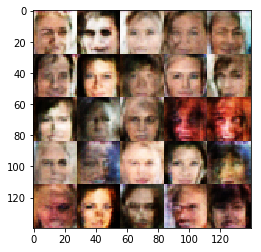

Epoch 0/1... Discriminator Loss: 1.3180... Generator Loss: 0.8056
Epoch 0/1... Discriminator Loss: 1.3044... Generator Loss: 0.7663
Epoch 0/1... Discriminator Loss: 0.9550... Generator Loss: 1.2039
Epoch 0/1... Discriminator Loss: 1.4433... Generator Loss: 0.5561
Epoch 0/1... Discriminator Loss: 1.3146... Generator Loss: 0.6941
Epoch 0/1... Discriminator Loss: 1.2756... Generator Loss: 0.8758
Epoch 0/1... Discriminator Loss: 1.3547... Generator Loss: 0.6741
Epoch 0/1... Discriminator Loss: 1.5048... Generator Loss: 0.5061
Epoch 0/1... Discriminator Loss: 1.2915... Generator Loss: 0.7508
Epoch 0/1... Discriminator Loss: 1.3868... Generator Loss: 0.6809


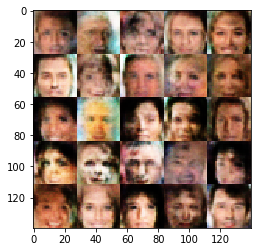

Epoch 0/1... Discriminator Loss: 1.2896... Generator Loss: 0.6260
Epoch 0/1... Discriminator Loss: 1.1707... Generator Loss: 1.0505
Epoch 0/1... Discriminator Loss: 1.2236... Generator Loss: 1.2910
Epoch 0/1... Discriminator Loss: 1.2905... Generator Loss: 1.2084
Epoch 0/1... Discriminator Loss: 1.1960... Generator Loss: 0.9228
Epoch 0/1... Discriminator Loss: 1.3191... Generator Loss: 0.6941
Epoch 0/1... Discriminator Loss: 1.3049... Generator Loss: 0.7390
Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 0.9181
Epoch 0/1... Discriminator Loss: 1.3697... Generator Loss: 0.7001
Epoch 0/1... Discriminator Loss: 1.3345... Generator Loss: 0.6752


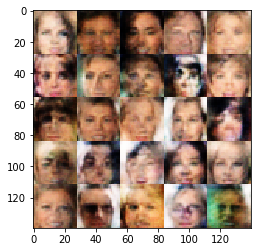

Epoch 0/1... Discriminator Loss: 1.2590... Generator Loss: 0.7913
Epoch 0/1... Discriminator Loss: 1.3143... Generator Loss: 0.7772
Epoch 0/1... Discriminator Loss: 0.9312... Generator Loss: 1.2403
Epoch 0/1... Discriminator Loss: 1.2705... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.2651... Generator Loss: 0.9723
Epoch 0/1... Discriminator Loss: 1.2574... Generator Loss: 0.7967
Epoch 0/1... Discriminator Loss: 1.3143... Generator Loss: 0.9543
Epoch 0/1... Discriminator Loss: 1.3517... Generator Loss: 0.8305
Epoch 0/1... Discriminator Loss: 1.3365... Generator Loss: 0.7080
Epoch 0/1... Discriminator Loss: 1.6372... Generator Loss: 1.7973


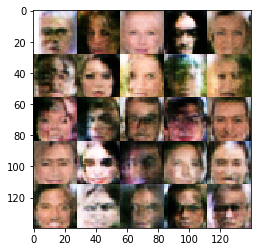

Epoch 0/1... Discriminator Loss: 1.5177... Generator Loss: 0.6144
Epoch 0/1... Discriminator Loss: 1.0725... Generator Loss: 1.0989
Epoch 0/1... Discriminator Loss: 1.3613... Generator Loss: 0.6978
Epoch 0/1... Discriminator Loss: 1.2115... Generator Loss: 0.8120
Epoch 0/1... Discriminator Loss: 1.1709... Generator Loss: 0.9820
Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 0.6559
Epoch 0/1... Discriminator Loss: 1.2681... Generator Loss: 0.7135
Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 0.9183
Epoch 0/1... Discriminator Loss: 1.2548... Generator Loss: 1.1570
Epoch 0/1... Discriminator Loss: 1.3113... Generator Loss: 0.8880


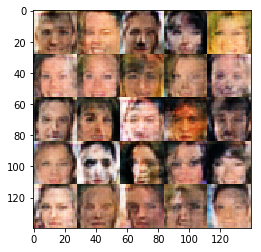

Epoch 0/1... Discriminator Loss: 1.1406... Generator Loss: 0.9497
Epoch 0/1... Discriminator Loss: 1.4383... Generator Loss: 0.6287
Epoch 0/1... Discriminator Loss: 1.3379... Generator Loss: 0.6422
Epoch 0/1... Discriminator Loss: 1.3281... Generator Loss: 0.7039
Epoch 0/1... Discriminator Loss: 1.2273... Generator Loss: 1.2164
Epoch 0/1... Discriminator Loss: 1.3309... Generator Loss: 0.6318
Epoch 0/1... Discriminator Loss: 1.2250... Generator Loss: 0.9200
Epoch 0/1... Discriminator Loss: 1.0416... Generator Loss: 0.8825
Epoch 0/1... Discriminator Loss: 1.4045... Generator Loss: 0.6880
Epoch 0/1... Discriminator Loss: 1.3668... Generator Loss: 0.8626


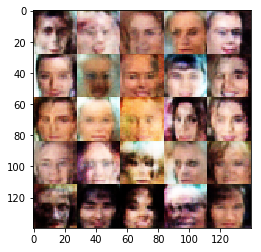

Epoch 0/1... Discriminator Loss: 1.3935... Generator Loss: 0.6117
Epoch 0/1... Discriminator Loss: 1.1440... Generator Loss: 1.0702
Epoch 0/1... Discriminator Loss: 1.3539... Generator Loss: 0.5546
Epoch 0/1... Discriminator Loss: 1.3749... Generator Loss: 0.5824
Epoch 0/1... Discriminator Loss: 1.3720... Generator Loss: 0.5630
Epoch 0/1... Discriminator Loss: 1.1981... Generator Loss: 0.8553
Epoch 0/1... Discriminator Loss: 1.3164... Generator Loss: 0.6786
Epoch 0/1... Discriminator Loss: 1.2018... Generator Loss: 0.8789
Epoch 0/1... Discriminator Loss: 1.4768... Generator Loss: 0.5121
Epoch 0/1... Discriminator Loss: 1.3739... Generator Loss: 0.6245


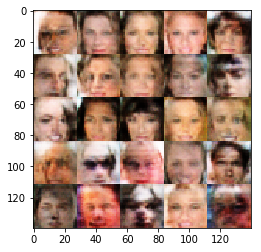

In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.